In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# importing the necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import gc 
import cv2 
import tensorflow as tf
from tensorflow import keras
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv
/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7

In [4]:
# Data Loading and Inspection 
data = "../input/planets-dataset/"
os.listdir(data)

['planet', 'test-jpg-additional']

In [5]:
# load the image datasets
train_trajectory = '../input/planets-dataset/planet/planet/train_classes.csv'
test_trajectory = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

In [6]:
# loading the training set
train_df = pd.read_csv(train_trajectory)
print(train_df.shape)
train_df.head()

(40479, 2)


image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [7]:
# loading the test set
test_df = pd.read_csv(test_trajectory)
test_df.shape

(61191, 2)

In [8]:
test_df.head()

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

## Exploratory Data Analysis

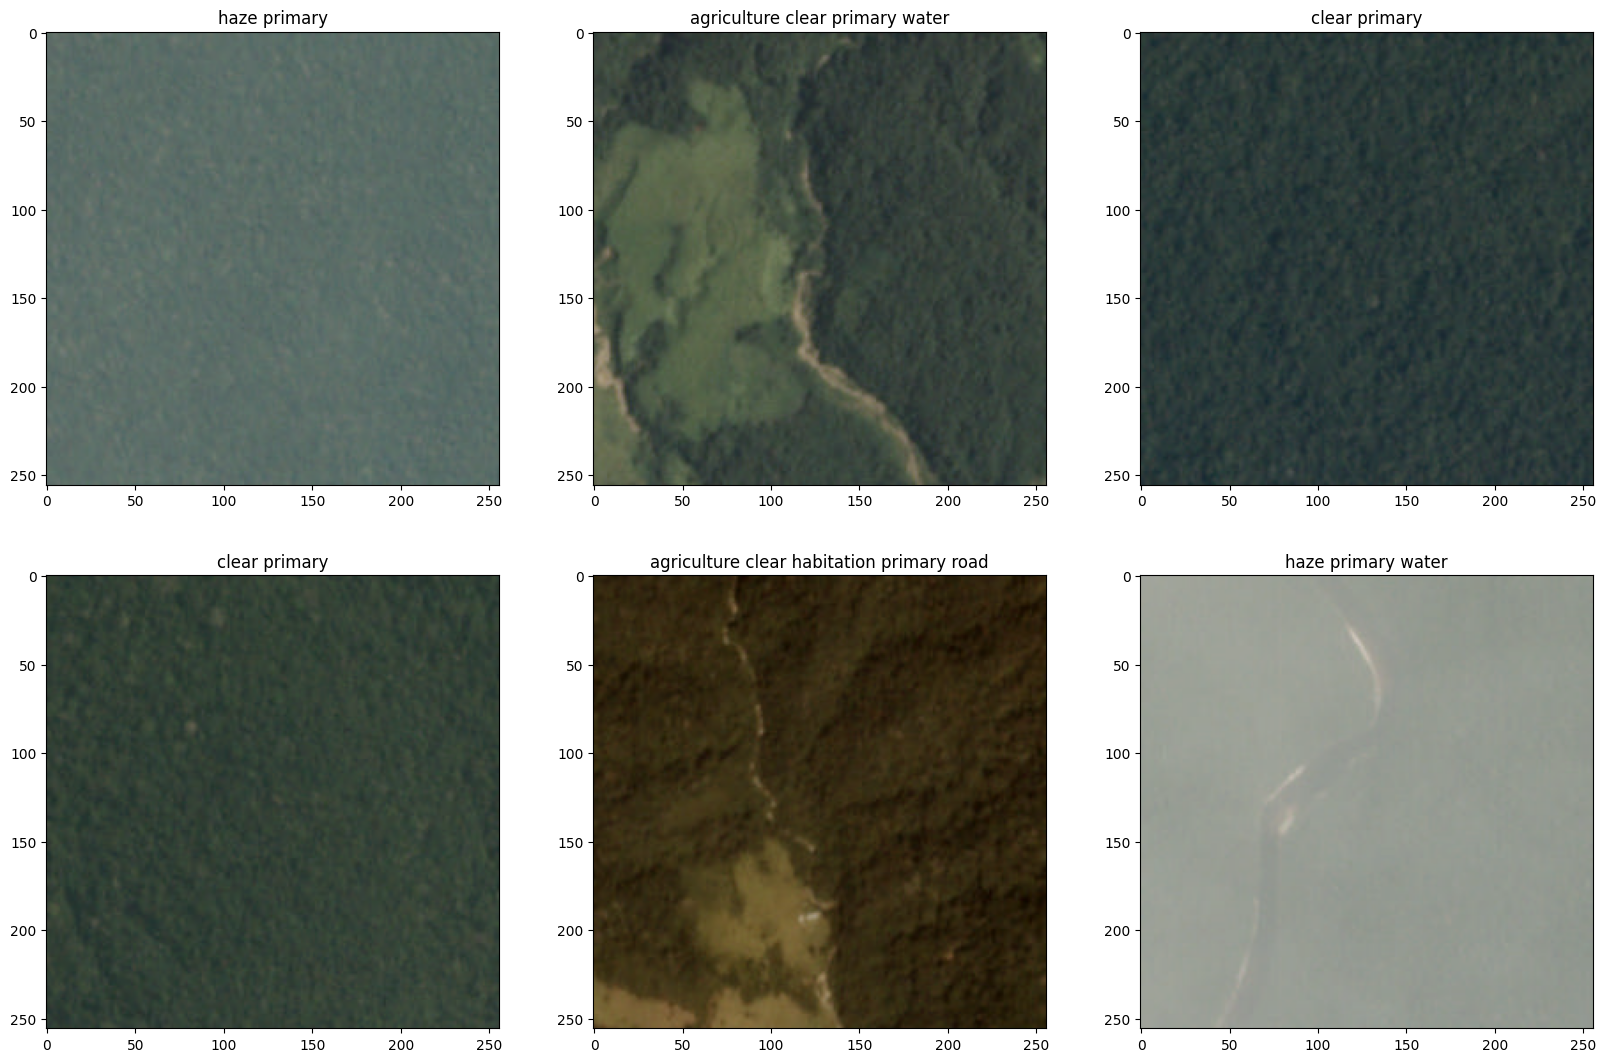

In [9]:
# checking out some images
plt.figure(figsize=(20,20))
# define location of the dataset
data_file = train_images

# plotting the first few images
for i in range(6):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define the filename
    filename = data_file + 'train_' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
    # add label on top of each image
    plt.title(f"{train_df['tags'][i]}")
    
# show the figure
plt.show()

In [10]:
# number of images in the training set
print(f'Number of images: {train_df.shape[0]}')

Number of images: 40479


In [11]:
# number of unique classes in the train dataset
unique_class=train_df['tags'].nunique()
print(f'There are {unique_class} unique classes in the train dataset')

There are 449 unique classes in the train dataset


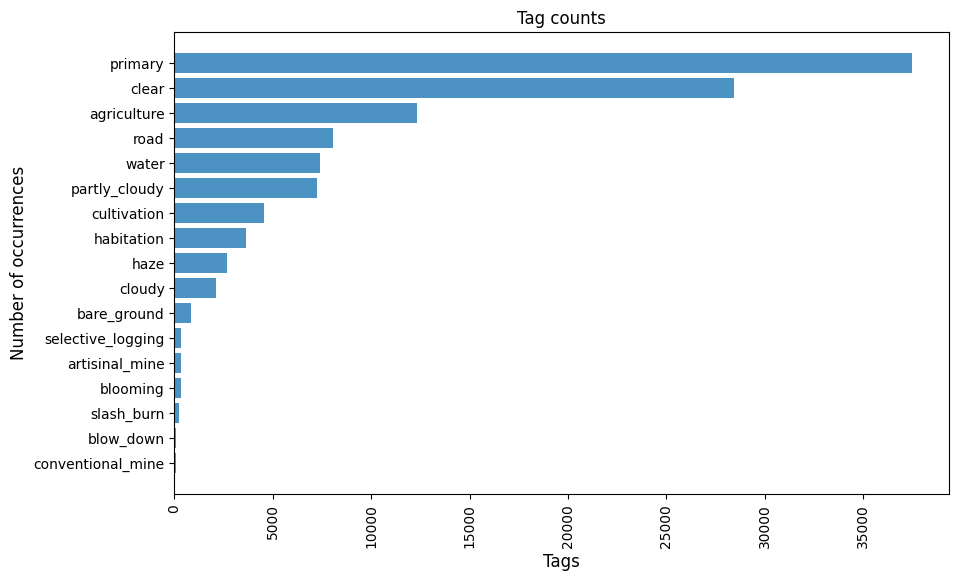

In [12]:
# tags present in the training set
tags = train_df['tags'].apply(lambda x: x.split(' '))
tags = [item for sublist in tags for item in sublist]
tag_counts = pd.Series(tags).value_counts()

# plot the tags
plt.figure(figsize=(10,6))
plt.barh(tag_counts.index, tag_counts.values, alpha=0.8)
plt.title('Tag counts')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show();

## Preprocessing

In [13]:
# using set() for storing only the unique tags
labels = set()
def split_tags(tags):
    '''
    This takes in the tags column, splits the tags and stores it as a set
    '''
    [labels.add(tag) for tag in tags.split()]
    
# create a copy of `train_df`
train_df_copy = train_df.copy()
train_df_copy['tags'].apply(split_tags)
labels = list(labels)
print(labels)

['slash_burn', 'blooming', 'clear', 'conventional_mine', 'artisinal_mine', 'road', 'agriculture', 'haze', 'cultivation', 'selective_logging', 'blow_down', 'habitation', 'partly_cloudy', 'bare_ground', 'cloudy', 'primary', 'water']


In [14]:
#  performing one hot encoding on the labels in train classes 
for tag in labels:
    train_df_copy[tag] = train_df_copy['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding .jpg extension to the column image_name so as to have same name format as the image files
train_df_copy['image_name'] = train_df_copy['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df_copy.head()

image_name                                       tags  slash_burn  \
0  train_0.jpg                               haze primary           0   
1  train_1.jpg            agriculture clear primary water           0   
2  train_2.jpg                              clear primary           0   
3  train_3.jpg                              clear primary           0   
4  train_4.jpg  agriculture clear habitation primary road           0   

   blooming  clear  conventional_mine  artisinal_mine  road  agriculture  \
0         0      0                  0               0     0            0   
1         0      1                  0               0     0            1   
2         0      1                  0               0     0            0   
3         0      1                  0               0     0            0   
4         0      1                  0               0     1            1   

   haze  cultivation  selective_logging  blow_down  habitation  partly_cloudy  \
0     1            0                  0          0           0              0   
1     0            0                  0          0           0              0   
2     0            0                  0          0           0              0   
3     0            0                  0          0           0              0   
4     0            0                  0          0           1              0   

   bare_ground  cloudy  primary  water  
0            0       0        1      0  
1            0       0        1      1  
2            0       0        1      0  
3            0       0        1      0  
4            0       0        1      0

In [15]:
# define the columns
columns = list(train_df_copy.columns[2:])
columns

['slash_burn',
 'blooming',
 'clear',
 'conventional_mine',
 'artisinal_mine',
 'road',
 'agriculture',
 'haze',
 'cultivation',
 'selective_logging',
 'blow_down',
 'habitation',
 'partly_cloudy',
 'bare_ground',
 'cloudy',
 'primary',
 'water']

In [16]:
# initializing imagedatagenerator with a validation split of 0.2
train_data_gen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# generating train data generator 
train_generator = train_data_gen.flow_from_dataframe(dataframe=train_df_copy,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

# Now, generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
validation_gen = train_data_gen.flow_from_dataframe(dataframe=train_df_copy,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


## Model Training

In [17]:
# define the model
def cnn_model():
    model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # convoluted layers
    Flatten(),
    # fully connected layers
    Dense(units=512, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=17, activation='sigmoid')    
    ])
    
    # compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [18]:
# initialize the model
model = cnn_model()

# preview the architectures of the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [19]:
# defining callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [20]:
# setting up step size for the training and validation image data
step_training_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_validation_size = int(np.ceil(validation_gen.samples / validation_gen.batch_size))

# fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_training_size, 
                    validation_data = validation_gen,
                    validation_steps = step_validation_size,
                    epochs = 10, 
                    callbacks = [earlystop])

Epoch 1/10
1012/1012 [==============================] - 971s 958ms/step - loss: 0.2033 - accuracy: 0.0562 - val_loss: 0.1541 - val_accuracy: 0.0775
Epoch 2/10
1012/1012 [==============================] - 934s 923ms/step - loss: 0.1552 - accuracy: 0.1453 - val_loss: 0.1430 - val_accuracy: 0.0870
Epoch 3/10
1012/1012 [==============================] - 936s 925ms/step - loss: 0.1438 - accuracy: 0.1776 - val_loss: 0.1366 - val_accuracy: 0.1055
Epoch 4/10
1012/1012 [==============================] - 930s 919ms/step - loss: 0.1364 - accuracy: 0.2066 - val_loss: 0.1327 - val_accuracy: 0.1015
Epoch 5/10
1012/1012 [==============================] - 932s 921ms/step - loss: 0.1292 - accuracy: 0.2069 - val_loss: 0.1250 - val_accuracy: 0.1267
Epoch 6/10
1012/1012 [==============================] - 950s 938ms/step - loss: 0.1237 - accuracy: 0.2309 - val_loss: 0.1298 - val_accuracy: 0.0938
Epoch 7/10
1012/1012 [==============================] - 949s 938ms/step - loss: 0.1159 - accuracy: 0.2236 - val_

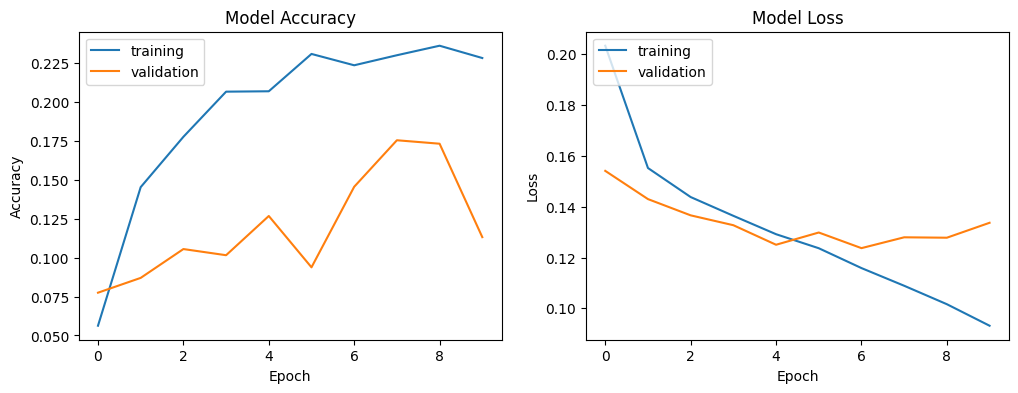

In [22]:
# plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()


In [23]:
# initializing a another model to make predictions
model1 = cnn_model()

In [24]:
# adding .jpg extension to image name in the sample submission file

sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_copy = sample_submission.copy()

sample_submission_copy['image_name'] = sample_submission_copy['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission_copy.head()

image_name                                  tags
0  test_0.jpg  primary clear agriculture road water
1  test_1.jpg  primary clear agriculture road water
2  test_2.jpg  primary clear agriculture road water
3  test_3.jpg  primary clear agriculture road water
4  test_4.jpg  primary clear agriculture road water

In [25]:
# the sample submission file was divided into two splits,
# the first test1_df contains the first 40600 images 
test_df1 = sample_submission_copy.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df1.head()

image_name
0  test_0.jpg
1  test_1.jpg
2  test_2.jpg
3  test_3.jpg
4  test_4.jpg

In [26]:
# initialize imagedatagenerator for the test images and also rescaling
test_data_gen = ImageDataGenerator(rescale = 1/255)

# creating a generator for the images found in the first test image files
test_gen = test_data_gen.flow_from_dataframe(dataframe=test_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))

Found 40669 validated image filenames.


In [27]:
# reset the test generator to avoid shuffling of index 
test_gen.reset()
pred = model1.predict(test_gen, steps=step_test_size1, verbose=1)

# get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

#then the result should look like this 
first_result = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
first_result.head()

1271/1271 [==============================] - 393s 309ms/step


image_name                                               tags
0  test_0.jpg  slash_burn clear artisinal_mine road cultivati...
1  test_1.jpg  slash_burn clear conventional_mine artisinal_m...
2  test_2.jpg  slash_burn conventional_mine artisinal_mine ro...
3  test_3.jpg  slash_burn clear conventional_mine artisinal_m...
4  test_4.jpg  slash_burn clear artisinal_mine road cultivati...

In [29]:
#second batch of the test dataset
additional_df = sample_submission_copy.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

image_name
0     file_0.jpg
1     file_1.jpg
2    file_10.jpg
3   file_100.jpg
4  file_1000.jpg

In [31]:
# creating a generator for the second batch of test image files
test_gen1 = test_data_gen.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 20522 validated image filenames.


In [32]:
# reset the generator to avoid shuffling, and then make prediction on the generator
test_gen1.reset()
pred1 = model1.predict(test_gen1, steps = step_test_size2, verbose = 1)

# get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

# convert the predicted values to a dataframe
# join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

second_result = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
second_result.head()

642/642 [==============================] - 187s 291ms/step


image_name                                               tags
0     file_0.jpg  slash_burnclearartisinal_mineroadcultivationbl...
1     file_1.jpg  slash_burnclearconventional_mineartisinal_mine...
2    file_10.jpg  slash_burnclearartisinal_mineroadcultivationha...
3   file_100.jpg  slash_burnclearconventional_mineartisinal_mine...
4  file_1000.jpg  slash_burnclearartisinal_mineroadcultivationbl...

In [34]:
# final result of the predicted tags for the test images,
# concat the first and second results in that order to avoid shuffling the index
combined_df = pd.concat([first_result, second_result])

combined_df = combined_df.reset_index().drop('index', axis =1)

print(combined_df.shape)
combined_df.head()

(61191, 2)


image_name                                               tags
0  test_0.jpg  slash_burn clear artisinal_mine road cultivati...
1  test_1.jpg  slash_burn clear conventional_mine artisinal_m...
2  test_2.jpg  slash_burn conventional_mine artisinal_mine ro...
3  test_3.jpg  slash_burn clear conventional_mine artisinal_m...
4  test_4.jpg  slash_burn clear artisinal_mine road cultivati...

In [35]:
# remove the .jpg extension from the image_name of the last_result 
combined_df['image_name'] = combined_df['image_name'].apply(lambda x: x[:-4])
combined_df.head()

image_name                                               tags
0     test_0  slash_burn clear artisinal_mine road cultivati...
1     test_1  slash_burn clear conventional_mine artisinal_m...
2     test_2  slash_burn conventional_mine artisinal_mine ro...
3     test_3  slash_burn clear conventional_mine artisinal_m...
4     test_4  slash_burn clear artisinal_mine road cultivati...

In [36]:
# Lastly, saving the result to a csv file and setting the index to false
combined_df.to_csv('submission.csv', index = False)